## LAB10
## STUDENT NAME:AYODELE AWOLEYE
## STUDENT iD:8900611

## IMPORT ALL NECESSARY LIBRARIES

In [1]:
import sklearn
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
import matplotlib.pyplot as plt
import os
import shutil
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, auc
from keras.utils import to_categorical
from sklearn.preprocessing import label_binarize

In [2]:
# Get dataset
# find 3 classes with the highest number of images

# use train data to find
train_folder = pathlib.Path("C:/8010 LABSUBMISSION/Lab/train")

# train_folder = pathlib.Path('../data/birds/train')
test_folder = pathlib.Path('C:/8010 LABSUBMISSION/Lab/test')
valid_folder = pathlib.Path('C:/8010 LABSUBMISSION/Lab/valid')
train_folder

WindowsPath('C:/8010 LABSUBMISSION/Lab/train')

In [3]:
# dict to store image count for each class
image_count = {}

# Loop through sub directories and update the count for each class
for species in os.listdir(train_folder):
    species_path = os.path.join(train_folder, species)
    if os.path.isdir(species_path):
        image_count[species] = len(os.listdir(species_path))

# sort the dictionary to list 3 top class
top_3_class = sorted(image_count, key=image_count.get, reverse=True)[:3]

print('Top 3 class with highest number of images:', top_3_class)

Top 3 class with highest number of images: ['RUFOUS TREPE', 'HOUSE FINCH', 'D-ARNAUDS BARBET']


# delete other directories for all the folder

In [4]:
# delete other directories for train folder
for species in os.listdir(train_folder):
    if species not in top_3_class:
        delete_path_train = os.path.join(train_folder, species)
        shutil.rmtree(delete_path_train)

# delete other directories for test folder
for species in os.listdir(test_folder):
    if species not in top_3_class:
        delete_path_test = os.path.join(test_folder, species)
        shutil.rmtree(delete_path_test)

# delete other directories for test folder
for species in os.listdir(valid_folder):
    if species not in top_3_class:
        delete_path_valid = os.path.join(valid_folder, species)
        shutil.rmtree(delete_path_valid)

# lets gets our clean data from all the classes

In [5]:
train_dataset = image_dataset_from_directory(
    train_folder,
    image_size=(224,224),
    batch_size=32
)

validation_dataset = image_dataset_from_directory(
    valid_folder,
    image_size=(224,224),
    batch_size=32
)

test_dataset = image_dataset_from_directory(
    test_folder,
    image_size=(224,224),
    batch_size=32
)

Found 744 files belonging to 3 classes.
Found 15 files belonging to 3 classes.
Found 15 files belonging to 3 classes.


Found 744 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


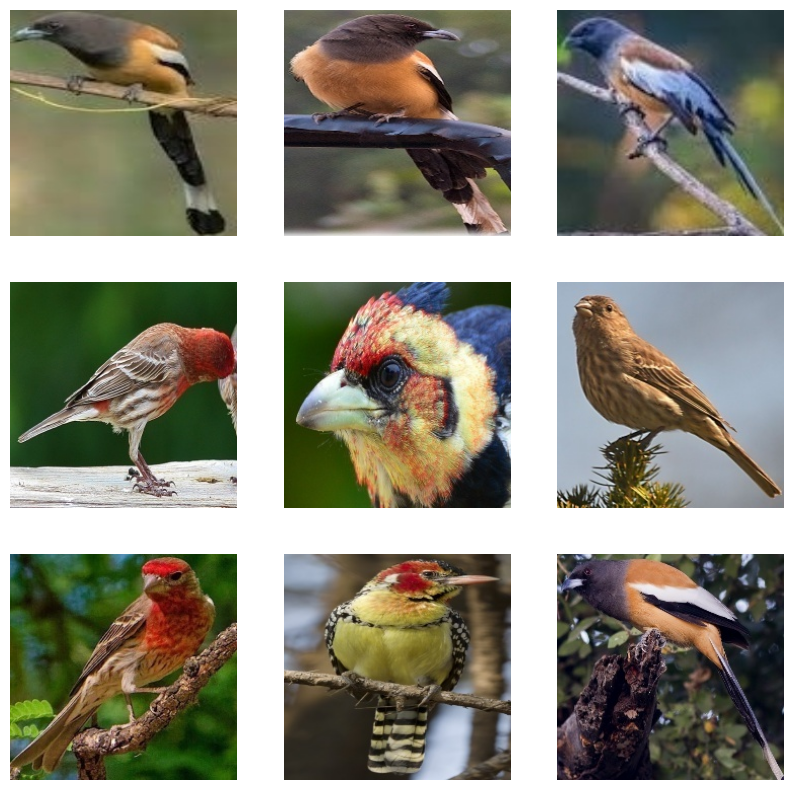

In [6]:
# use keras function of ImageDataGenerator.flow_from_directory

data_generator = ImageDataGenerator(
    horizontal_flip = True,
    fill_mode = 'nearest'
)

train_generator = data_generator.flow_from_directory(
    train_folder,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = data_generator.flow_from_directory(
    valid_folder,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# display some augmented training images

# get images and labels from train_generator
images, _ = next(train_generator)

plt.figure(figsize=(10, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].astype("uint8"))
    plt.axis("off")
plt.show()

In [7]:
# load pre-trained VGG16 model from imagenet
data_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

In [8]:
data_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [9]:
# add custom layers
x = data_model.output
x = GlobalAveragePooling2D()(x)
# add a new dense layer
x = Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)

# 3 classes
predictions = Dense(3, activation='softmax')(x)
model = Model(inputs=data_model.input, outputs=predictions)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# freeze all layers for the pretrained model for fine-tuning

In [10]:
data_model.trainable = False
data_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
# lets compile 

In [12]:
model.compile(loss='categorical_crossentropy', 
              optimizer='Adam', 
              metrics=['accuracy'])
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

Epoch 1/10
24/24 [==============================] - 589s 25s/step - loss: 1.6846 - accuracy: 0.8293 - val_loss: 2.1967e-04 - val_accuracy: 1.0000
Epoch 2/10
24/24 [==============================] - 568s 24s/step - loss: 0.4139 - accuracy: 0.9516 - val_loss: 5.0767e-04 - val_accuracy: 1.0000
Epoch 3/10
24/24 [==============================] - 566s 24s/step - loss: 0.2225 - accuracy: 0.9704 - val_loss: 2.0756e-05 - val_accuracy: 1.0000
Epoch 4/10
24/24 [==============================] - 565s 24s/step - loss: 0.2401 - accuracy: 0.9718 - val_loss: 2.7285e-05 - val_accuracy: 1.0000
Epoch 5/10
24/24 [==============================] - 566s 24s/step - loss: 0.0779 - accuracy: 0.9879 - val_loss: 5.1656e-06 - val_accuracy: 1.0000
Epoch 6/10
24/24 [==============================] - 565s 24s/step - loss: 0.0895 - accuracy: 0.9852 - val_loss: 7.3986e-06 - val_accuracy: 1.0000
Epoch 7/10
24/24 [==============================] - 566s 24s/step - loss: 0.0808 - accuracy: 0.9812 - val_loss: 2.8089e-04 -

In [13]:
# Accuracy for training and validation

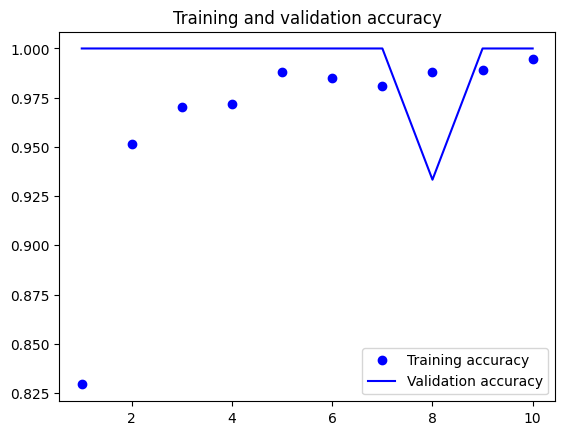

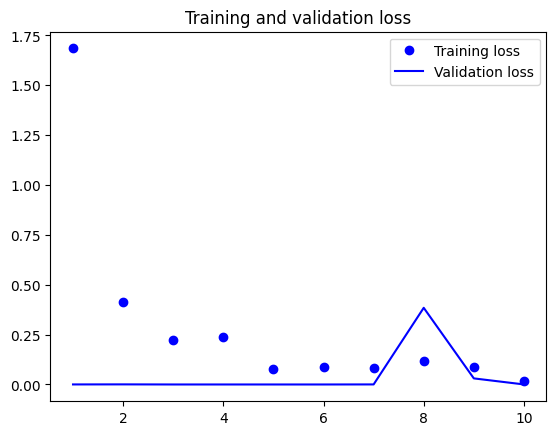

In [14]:

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [15]:
test_loss, test_acc = model.evaluate(validation_generator)
print(f"Test accuracy: {test_acc:.3f}")

1/1 [==============================] - 12s 12s/step - loss: 6.0271e-04 - accuracy: 1.0000
Test accuracy: 1.000


In [16]:
# Confusion matrix, Precision, Recall and F1-score
y_pred = model.predict(validation_generator)
y_pred_class = np.argmax(y_pred, axis=1)

y_true = validation_generator.classes

# confusion matrix
cm = confusion_matrix(y_true, y_pred_class)

# precision, recall and F1-score
print(classification_report(y_true, y_pred_class, target_names=validation_generator.class_indices.keys()))

1/1 [==============================] - 14s 14s/step
                  precision    recall  f1-score   support

D-ARNAUDS BARBET       0.00      0.00      0.00         5
     HOUSE FINCH       0.60      0.60      0.60         5
    RUFOUS TREPE       0.00      0.00      0.00         5

        accuracy                           0.20        15
       macro avg       0.20      0.20      0.20        15
    weighted avg       0.20      0.20      0.20        15



In [17]:
!pip install seaborn


In [ ]:
# let change these with our actual model predictions and true labels

In [ ]:
y_pred = model.predict(validation_generator)
y_pred_class = np.argmax(y_pred, axis=1)
y_true = validation_generator.classes


AUC for D-ARNAUDS BARBET: 0.24274891774891774
AUC for HOUSE FINCH: 0.7371212121212122
AUC for RUFOUS TREPE: 0.21975912975912976


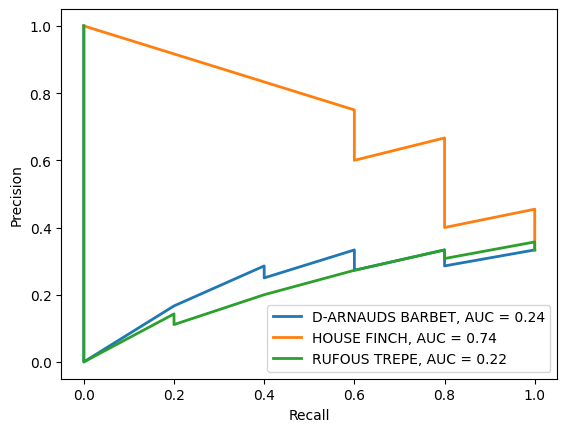

In [20]:
# convert true labels to one-hot encoding for multi-class
y_true_one_hot = to_categorical(y_true)
class_names = {v: k for k, v in validation_generator.class_indices.items()}

for i in range(3):
    precision, recall, _ = precision_recall_curve(y_true_one_hot[:, i], y_pred[:, i])
    auc_score = auc(recall, precision)
    class_name = class_names[i]
    print(f'AUC for {class_name}: {auc_score}')
    plt.plot(recall, precision, lw=2, label='{}, AUC = {:.2f}'.format(class_name, auc_score))

# plot

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

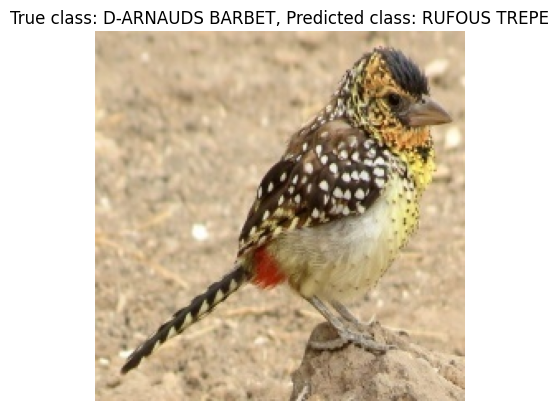

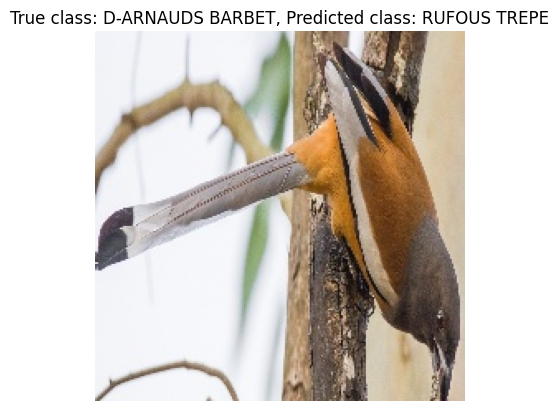

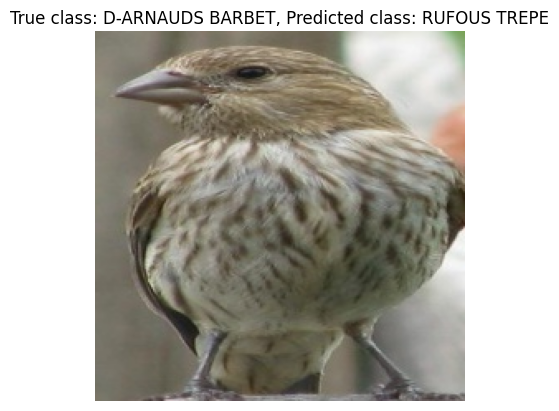

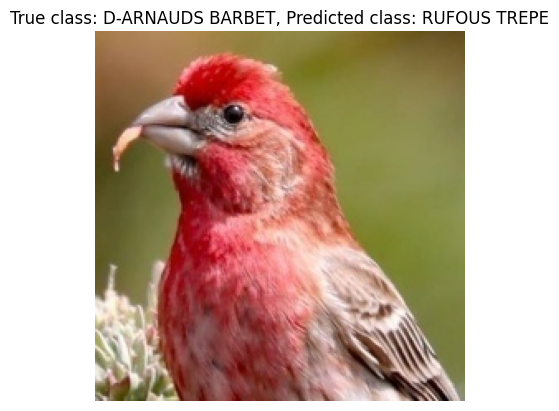

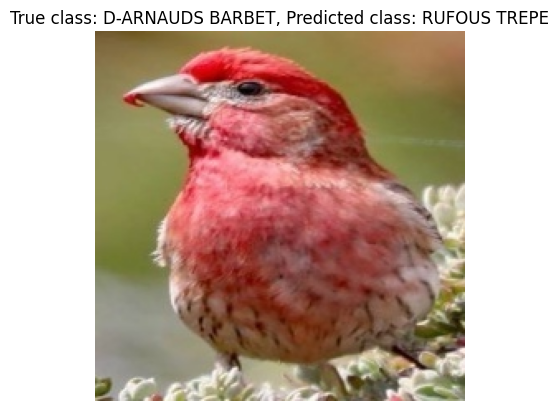

In [21]:
# explore incorrectly predicted examples
misclassfied_index = np.where(y_pred_class != y_true)[0]

# plot specific examples
for index in misclassfied_index[:5]:
    # get image from corresponding batch
    img_batch, _ = validation_generator[index // validation_generator.batch_size]
    img = img_batch[index % validation_generator.batch_size]
    
    true_class_name = class_names[y_true[index]]
    predicted_class_name = class_names[y_pred_class[index]]

    plt.imshow(img.astype('uint8'))
    plt.title(f'True class: {true_class_name}, Predicted class: {predicted_class_name}')
    plt.axis('off')
    plt.show()